## Advanced Analysis
This section contains our project plan and temporary analysis cells. Our goal will be to migrate each of these cells into individual scripts, addressable through Make.

**Ultimate Goal**: Determine which hours are most efficient in the data, which suppliers are responsible are for their hours, and then attempt to predict what energy usage could look like in the future if more energy is shifted to the most efficient suppliers.

#### Project Plan

1. ✅ **Initial Data Exploration and Feature Selection**
   - Perform EDA on `fct_electric_brew`, `dim_datetimes`, `dim_bills`, focusing on `supplier`, `kwh`, `total_cost`, `hour`, `period`, and `month_name`. Explore trends and correlations, especially seasonal and hourly variations in `kwh` and `total_cost`.

   - **Target Variable:** Adopt `kwh_at_cost` as the primary metric (calculated as `kwh / total_cost`).
   - **Progression Logic:** EDA findings, especially on supplier impact, seasonal, and hourly variations, will guide feature engineering. The identified patterns will be critical for setting up the linear regression model.
   - **Packages:** Primarily `pandas` for data manipulation, `matplotlib.pyplot` and `seaborn` for visualizations.
   - **Visualization Techniques:** Use scatter plots, heatmaps, and seaborn's pairplot for exploring relationships and trends.
<br>

2. ✅ **Categorical Feature Engineering**
   - Quantify categorical variables like `supplier` from `dim_bills` and `period`, `month_name` from `dim_datetimes`. This will include one-hot encoding to capture their impacts on energy cost efficiency.
  
   - **Progression Logic:** Enhanced features, particularly from `dim_bills` and `dim_datetimes`, will be crucial in the linear regression model, offering a quantified view of how different time periods and suppliers influence `kwh_at_cost`.
   - **Packages:** Utilize `sklearn.preprocessing.OneHotEncoder` for encoding categorical variables.
   - **Visualization Techniques:** Bar plots to compare the impact of different categories post-encoding.
<br>

3. ✅ **Feature Pipelines**
   - Establish pipelines for data normalization (e.g., scaling `kwh` and `total_cost`) and encoding categorical features (`supplier`, `period`). Ensure consistency in data preparation for modeling.
  
   - **Progression Logic:** The feature pipeline will directly feed into the linear regression model, providing a standardized set of features for initial modeling and subsequent complex models.
   - **Packages:** Use `sklearn.pipeline.Pipeline` and `sklearn.compose.ColumnTransformer` for consistent data preprocessing.
   - **Visualization Techniques:** Box plots to visualize feature distributions post-normalization.
<br>

4. ✅ **Linear Regression with Initial Features**
   - Construct a linear regression model using variables like `supplier`, `hour`, `kwh`, and `period` to predict `kwh_at_cost`. This model will provide a baseline understanding of the relationships in the data.
  
   - **Progression Logic:** The linear regression model’s performance and insights, particularly regarding supplier impact and time-related features, will inform the need for and approach to polynomial modeling and decision trees.
   - **Packages:** `sklearn.linear_model.LinearRegression` for the regression analysis.
   - **Visualization Techniques:** Regression plots using seaborn to visualize actual vs. predicted values.
<br>

5. ❌ **Polynomial Basis Functions and Regularization**
   - Explore polynomial features to model complex non-linear trends, such as the interaction between `hour` and `kwh`. Apply regularization (e.g., Ridge or Lasso) to avoid overfitting.
  
   - **Progression Logic:** Insights from linear regression on key interactions will guide the use of polynomial features, preparing for a more nuanced understanding in tree-based models.
   - **Packages:** `sklearn.preprocessing.PolynomialFeatures` for polynomial transformation, and `sklearn.linear_model.Ridge` or `Lasso` for regularization.
   - **Visualization Techniques:** Residual plots to evaluate the fit and seaborn's regplot to visualize polynomial regressions.
<br>

6. ✅ **Decision Trees and Random Forests**
    - Develop decision tree and random forest models using refined features, focusing on capturing complex interactions and nonlinear relationships, such as the influence of specific `suppliers` and `meter_id` on `kwh_at_cost`.
  
    - **Progression Logic:** These models will build on the polynomial regression findings to provide a deeper understanding of feature interactions, setting the stage for cross-validation and anomaly detection.
    - **Packages:** `sklearn.tree.DecisionTreeRegressor` and `sklearn.ensemble.RandomForestRegressor` for tree-based models.
    - **Visualization Techniques:** Feature importance plots using matplotlib to understand predictive variables.
<br>

7. ✅ **Model Validation via Cross-Validation**
   - Perform cross-validation on the developed models to assess their performance stability across different temporal segments, evaluating how different suppliers, hours, and seasons affect predictions.
  
   - **Progression Logic:** Cross-validation findings will highlight model robustness and guide fine-tuning, particularly for models like random forests, which are prone to overfitting.
   - **Packages:** `sklearn.model_selection.cross_val_score` or `cross_validate` for robust model evaluation.
   - **Visualization Techniques:** Line plots to display model performance metrics across cross-validation folds.
<br>

8. ✅ **Anomaly Detection**
    - Apply anomaly detection techniques to identify unusual patterns in `kwh_at_cost`, focusing on anomalies potentially linked to specific suppliers, meter readings, or unusual time periods.
  
    - **Progression Logic:** Anomaly detection will provide insights into outliers or irregularities, feeding back into model refinement and offering a different perspective on data integrity and unusual consumption patterns.
    - **Packages:** `sklearn.ensemble.IsolationForest` or `LocalOutlierFactor` for detecting anomalies.
    - **Visualization Techniques:** Scatter plots highlighting anomalies within the data.
<br>

9. ✅ **K-Means Clustering**
    - Use K-Means clustering on `fct_electric_brew` to segment patterns based on energy consumption efficiency, particularly considering variables like `supplier`, `hour`, and `period`.
  
    - **Progression Logic:** Clustering will reveal distinct patterns and segments in energy usage, complementing predictive models and aiding in targeted efficiency improvement strategies.
    - **Packages:** `sklearn.cluster.KMeans` for clustering analysis.
    - **Visualization Techniques:** Cluster visualization using scatter plots, colored by cluster labels.
<br>

1.  ✅ **Selecting the Best Model**
    - Compare all developed models, focusing on their effectiveness in predicting `kwh_at_cost` and understanding patterns of energy efficiency across different suppliers and time periods.
  
    - **Progression Logic:** This comprehensive comparison will synthesize insights from each analytical step, culminating in the selection of the most effective model for strategic application.
    - **Packages:** Evaluation metrics like `sklearn.metrics.mean_squared_error` or `r2_score` for model comparison.
    - **Visualization Techniques:** Comparative bar or line charts for model performance evaluation.
<br>

1.  **Time-Based Forecasting**
    - Implement forecasting methods to project future `kwh_at_cost` trends, integrating temporal data from `dim_datetimes` and supplier information from `dim_bills`.
  
    - **Progression Logic:** Forecasting leverages accumulated insights from all prior analyses, especially the impact of time and suppliers, to predict future energy efficiency trends.
    - **Packages:** For time series forecasting, `statsmodels` alongside `sklearn.model_selection.TimeSeriesSplit` for time series cross-validation.
    - **Visualization Techniques:** Time series line plots to compare actual and forecasted values.
<br>

1.  **Bayesian Classification**
    - Conduct Bayesian classification to model the probability of achieving high energy efficiency under different supplier and time conditions.
  
    - **Progression Logic:** Bayesian classification will augment other models by adding a probabilistic understanding, particularly useful for decision-making under uncertainty.
    - **Packages:** `sklearn.naive_bayes.GaussianNB` for Gaussian Naive Bayes classification.
    - **Visualization Techniques:** Probability density plots for visualizing Bayesian classification results.
<br>

In [1]:
import numpy as np

from utils.dataframes import fct_electric_brew, dim_datetimes, dim_meters, dim_bills
from utils.runtime    import setup_plot_params

setup_plot_params()

df = fct_electric_brew.merge(dim_datetimes, how = 'left', left_on = 'dim_datetimes_id', right_on = 'id', suffixes = ('', '_dd')) \
                      .merge(dim_bills,     how = 'left', left_on = 'dim_bills_id',     right_on = 'id', suffixes = ('', '_db')) \

df['kwh_at_cost'] = np.where(df['total_cost'] != 0, df['kwh'] / df['total_cost'], df['kwh'])
df['supplier']    = df['supplier'].replace([np.nan, ''], 'Unspecified')

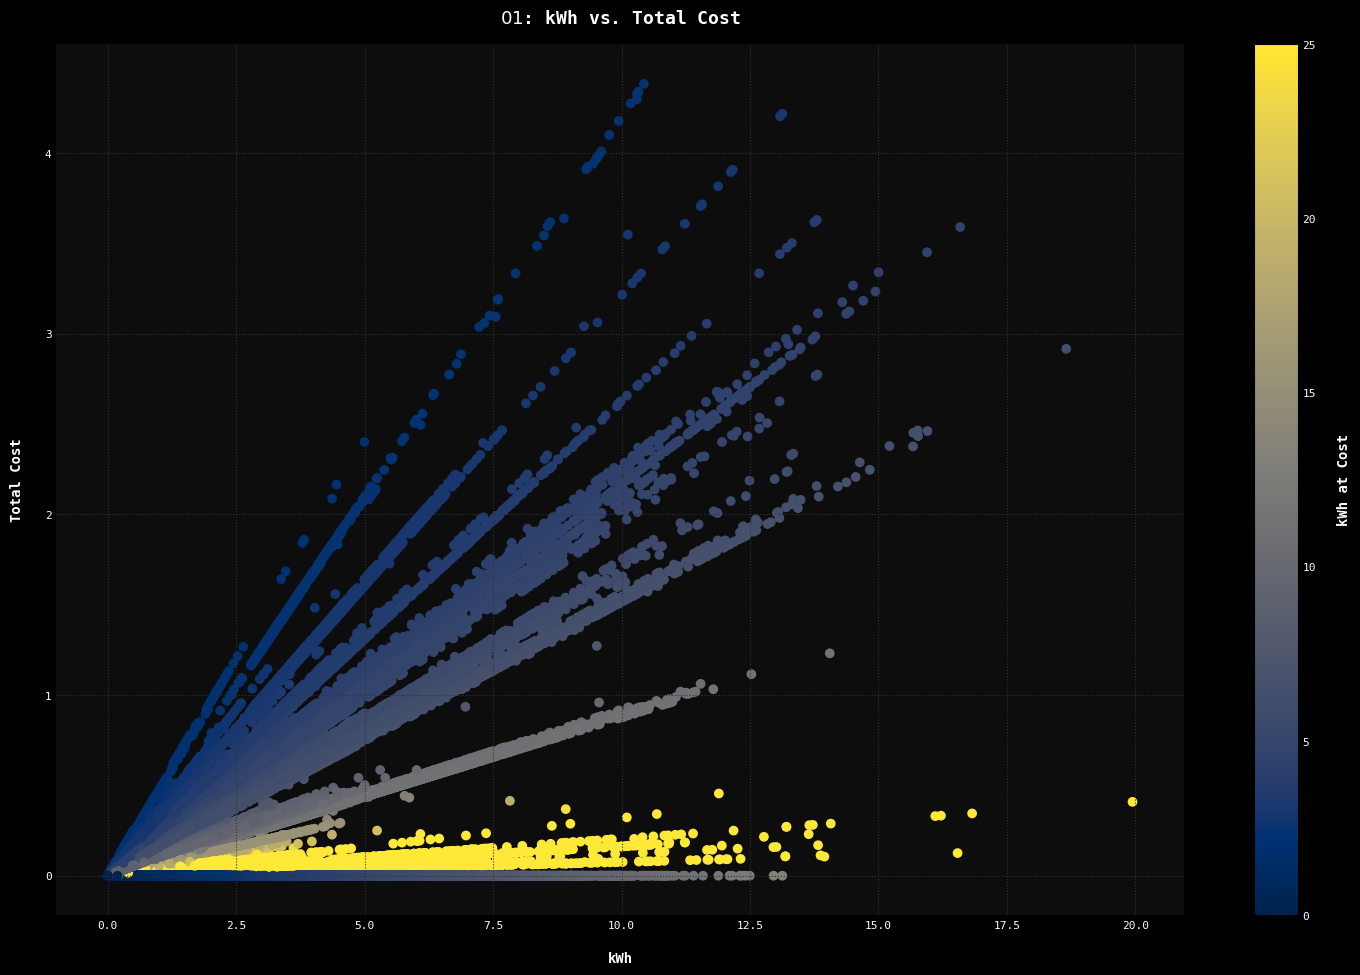

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from utils.runtime import find_project_root

plt.scatter(x = df['kwh'], 
            y = df['total_cost'],
            c = np.clip(df['kwh_at_cost'], a_min = None, a_max = 25),
            cmap      = 'cividis',
            edgecolor = None)

plt.title('$01$: kWh vs. Total Cost')
plt.xlabel('kWh')
plt.ylabel('Total Cost')
plt.colorbar(label = 'kWh at Cost')
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/01 - kWh vs. Total Cost.png'))
plt.show()

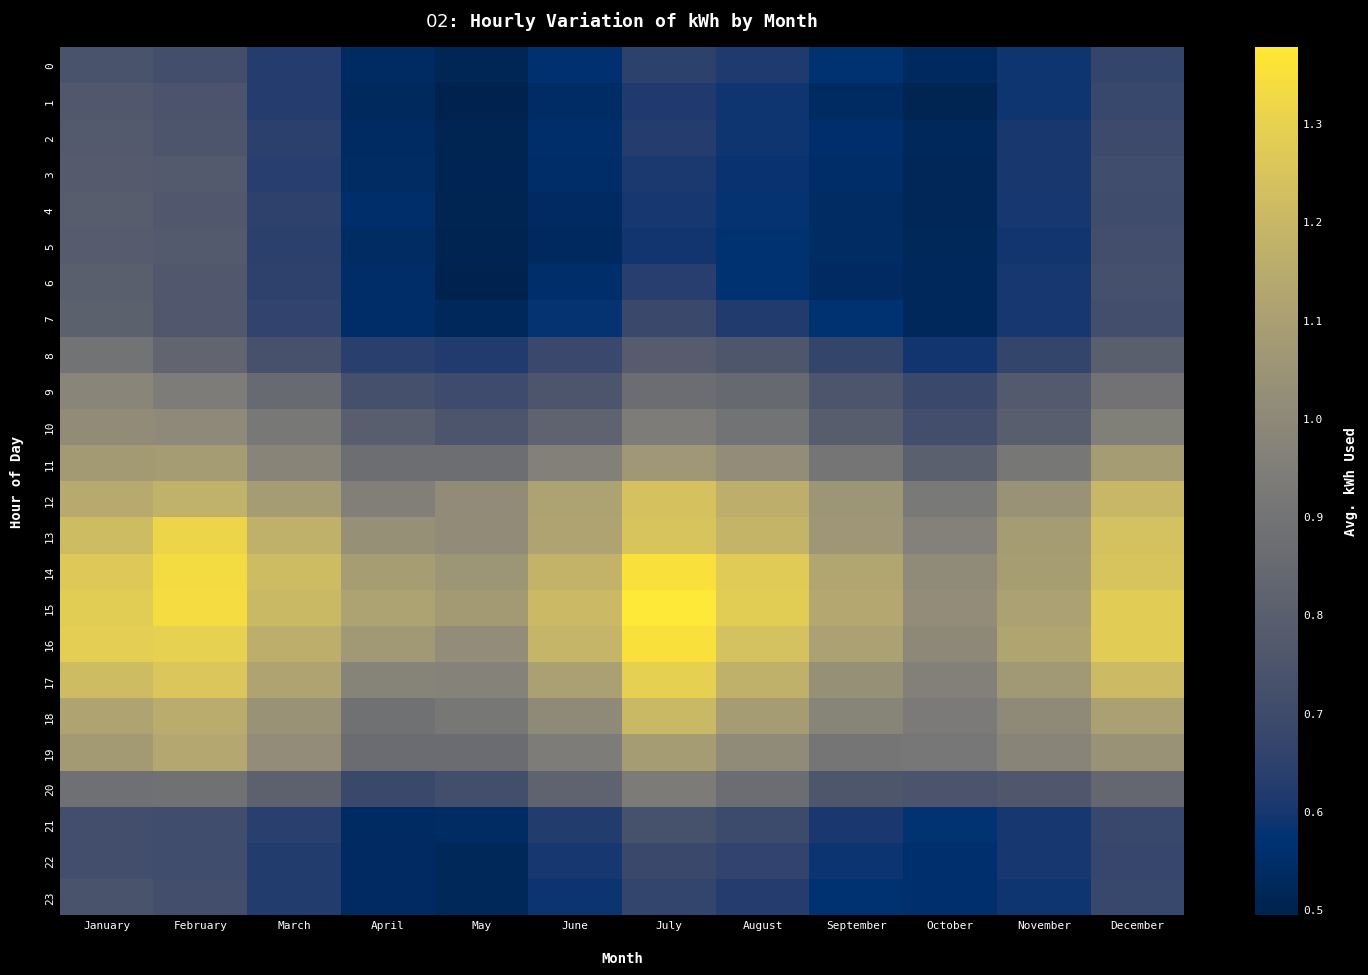

In [3]:
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

from utils.runtime import find_project_root

hourly_kwh_by_month = df.pivot_table(index   = 'hour', 
                                     columns = 'month', 
                                     values  = 'kwh', 
                                     aggfunc = 'mean')

p = sns.heatmap(hourly_kwh_by_month, 
                cmap     = 'cividis',
                cbar_kws = {'label' : 'Avg. kWh Used'})

# Set the month names as labels
month_names = [calendar.month_name[i] for i in range(1, 13)]
p.set_xticklabels(month_names)

plt.title('$02$: Hourly Variation of kWh by Month')
plt.xlabel('Month')
plt.ylabel('Hour of Day')
plt.grid(False)
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/02 - Hourly Variation of kWh by Month.png'))
plt.show()

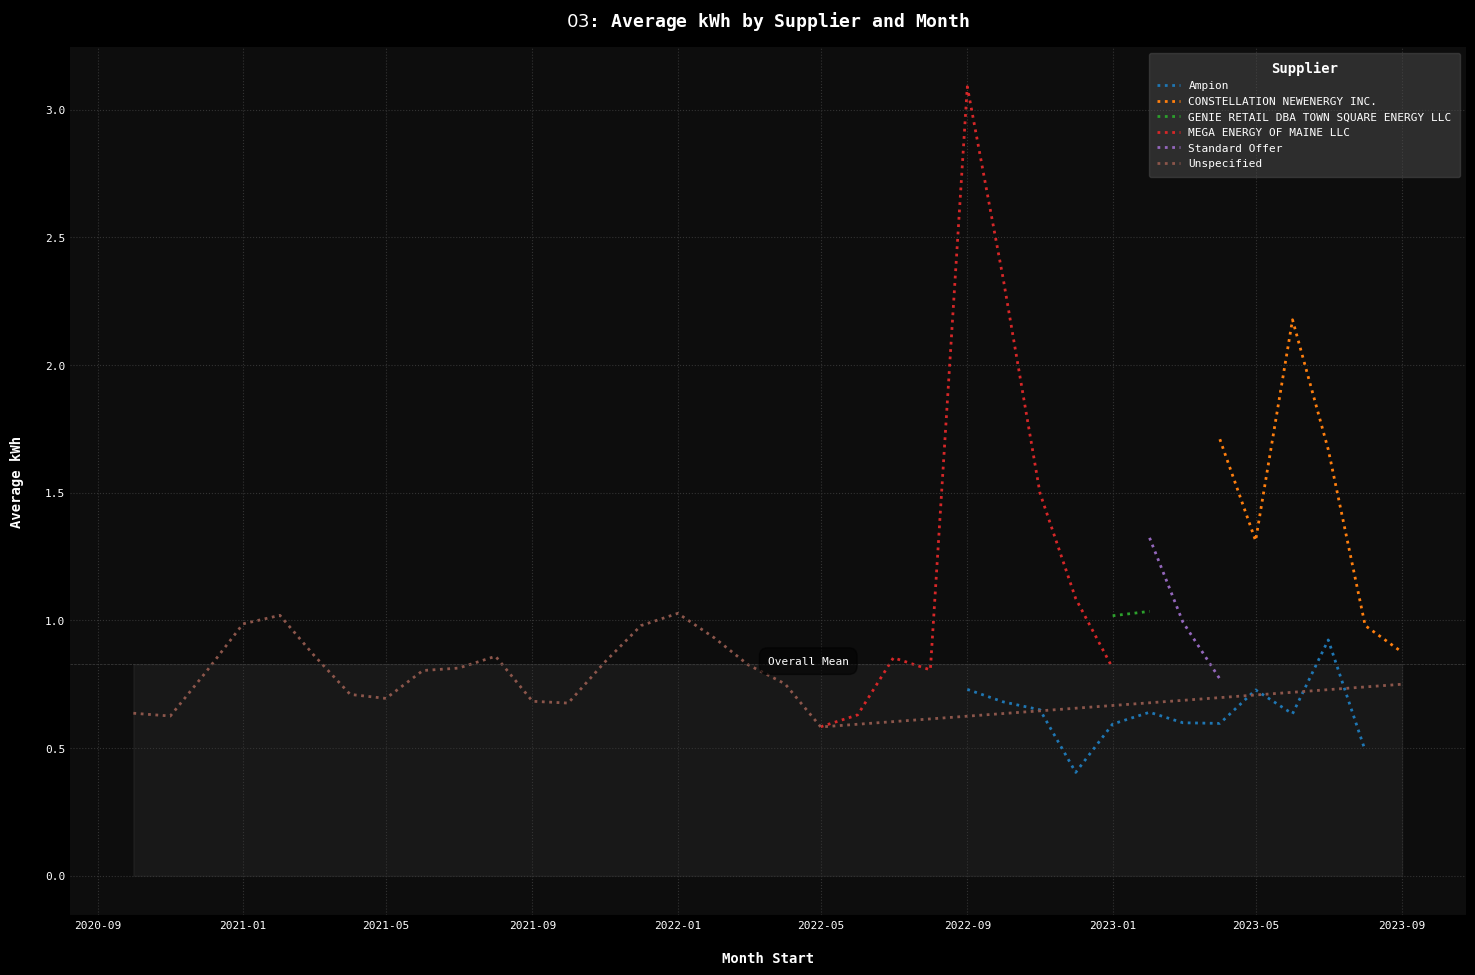

In [4]:
import matplotlib.pyplot as plt
import pandas  as pd
import seaborn as sns

from utils.runtime import find_project_root

# Group by both 'supplier' and 'month_start' and calculate the mean of 'kwh_at_cost'
dfg = df.groupby(['supplier', 'month_start'])['kwh'].mean().reset_index()

sns.lineplot(data = dfg, 
             x    = 'month_start', 
             y    = 'kwh', 
             hue  = 'supplier',
             linestyle = ':',
             linewidth = 2)

# Add shading for values below the overall mean
overall_mean = df['kwh'].mean()
min_date     = dfg['month_start'].min()
max_date     = dfg['month_start'].max()

plt.fill_between(x = pd.date_range(start = min_date,
                                   end   = max_date), 
                 y1 = 0, 
                 y2 = overall_mean, 
                 color = '0.5', 
                 alpha = 0.1)

plt.axhline(overall_mean, color = '0.25', linewidth = 0.5, linestyle = '--')

plt.text(x = min_date + (max_date - min_date) / 2,
         y = overall_mean,
         s = 'Overall Mean',
         bbox = dict(facecolor = '0', alpha = 0.5, boxstyle = 'round, pad = 0.75'))

plt.title('$03$: Average kWh by Supplier and Month')
plt.xlabel('Month Start')
plt.ylabel('Average kWh')
plt.legend(title = 'Supplier', title_fontproperties = {'weight' : 'bold', 'size' : 10})
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/03 - Average kWh by Supplier and Month.png'))
plt.show()

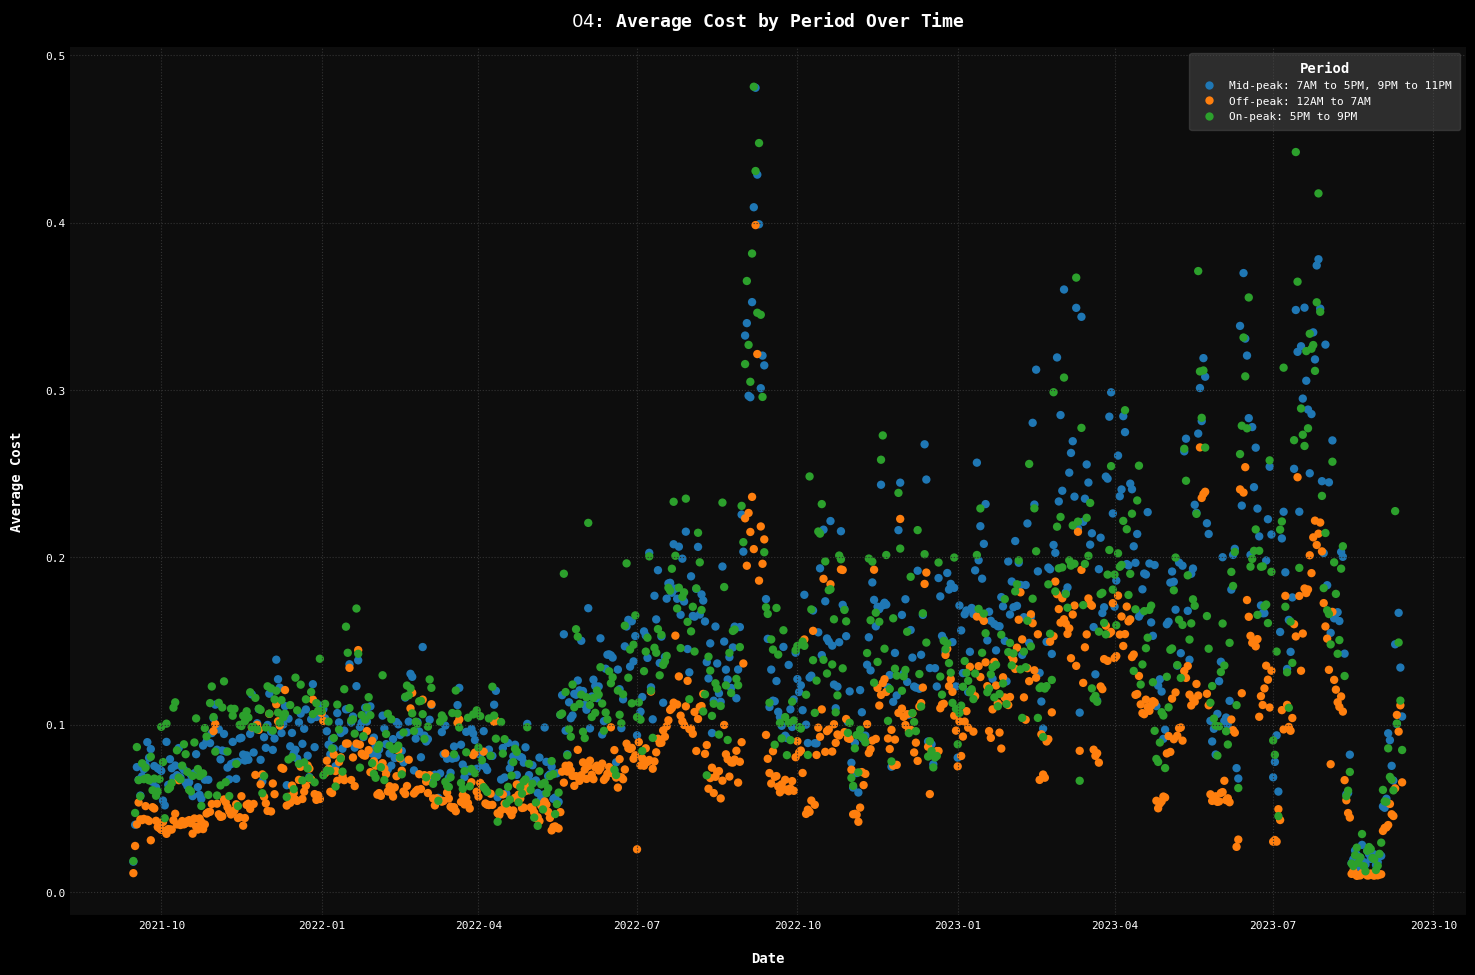

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.runtime import find_project_root

dfg = df.groupby(['period', 'date'])['total_cost'].mean().reset_index()

p = sns.scatterplot(data = dfg[dfg['total_cost'] > 0], 
                    x    = 'date', 
                    y    = 'total_cost', 
                    hue  = 'period',
                    linewidth = 0)

plt.title('$04$: Average Cost by Period Over Time')
plt.xlabel('Date')
plt.ylabel('Average Cost')
plt.legend(title = 'Period', title_fontproperties = {'weight' : 'bold', 'size' : 10})
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/04 - Average Cost by Period Over Time.png'))
plt.show()

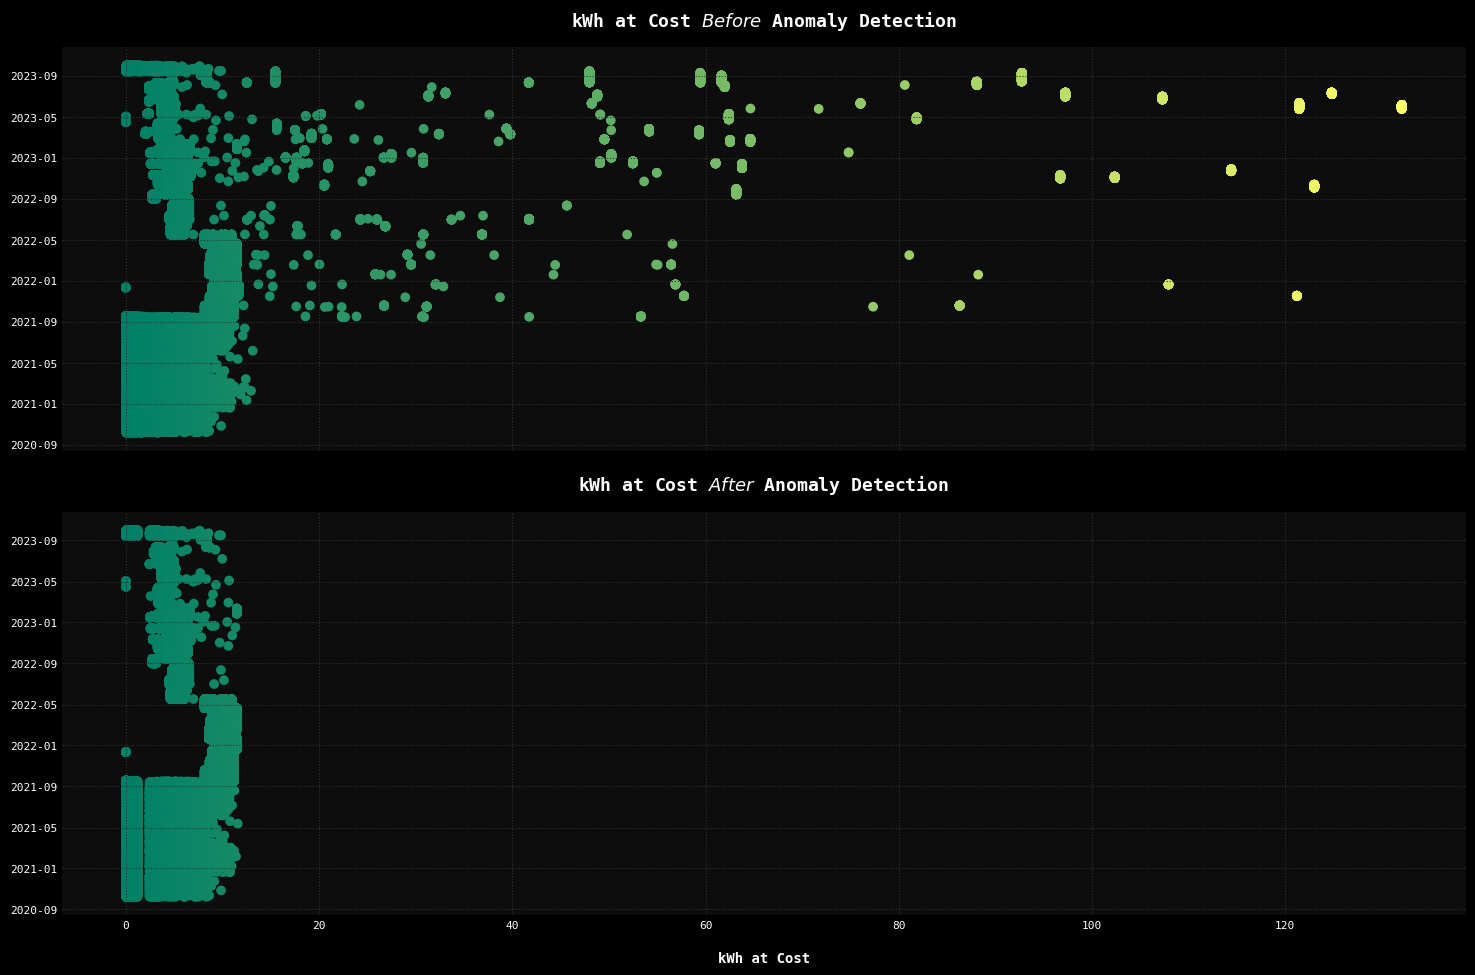

In [6]:
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from utils.runtime    import find_project_root

# Fit Isolation Forest using default `contamination` methodology
isolation_forest = IsolationForest(n_jobs = -1, random_state = 0)
outliers = isolation_forest.fit_predict(df[['kwh_at_cost']])

df_without_outliers = df[outliers == 1]
data_for_plotting = {'Before' : df, 
                     'After'  : df_without_outliers}

# Create subplots with shared x-axis
fig, axs = plt.subplots(2, 1, 
                        figsize = (15, 10), 
                        sharex = True, sharey = True)

# Loop through data and plot
colormap_range = (df['kwh_at_cost'].min(), df['kwh_at_cost'].max())

for i, (title, data) in enumerate(data_for_plotting.items()):
    axs[i].scatter(x = data['kwh_at_cost'],
                   y = data['timestamp'],
                   c = data['kwh_at_cost'],
                   cmap = 'summer',
                   vmin = colormap_range[0],
                   vmax = colormap_range[1],
                   edgecolor = None)
    
    axs[i].set_title(f"kWh at Cost ${title}$ Anomaly Detection")

    if i == len(data_for_plotting) - 1:
        axs[i].set_xlabel('kWh at Cost')

plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/05 - Applying Anomaly Detection with kWh at Cost.png'))
plt.show()

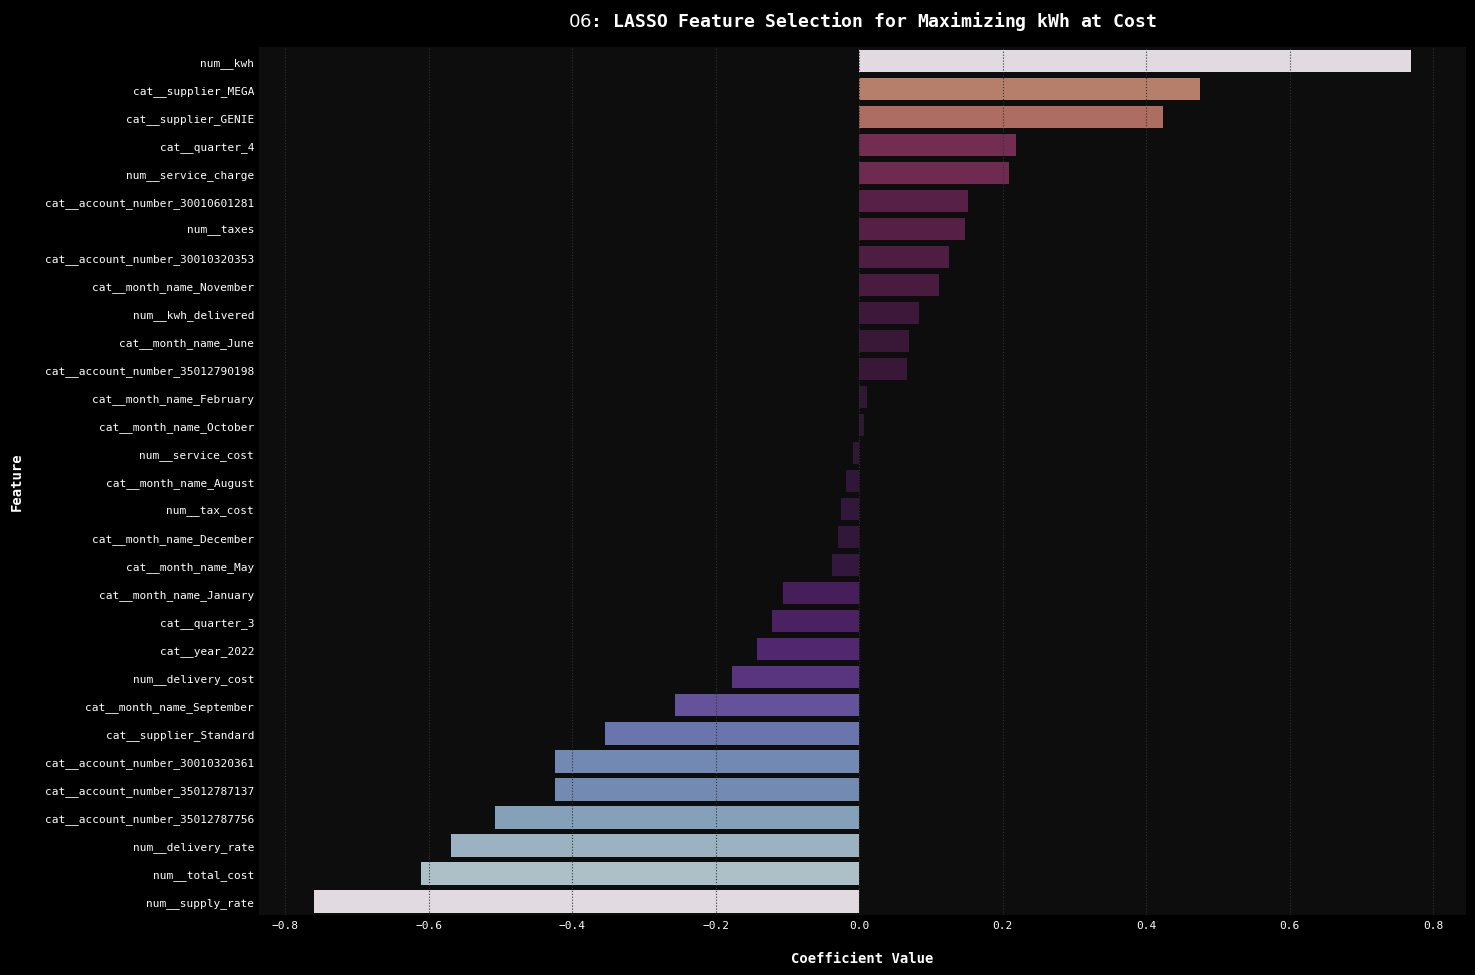

In [7]:
import matplotlib.pyplot as plt
import pandas  as pd
import seaborn as sns

from sklearn.compose           import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model      import LassoCV
from sklearn.model_selection   import train_test_split
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import OneHotEncoder, StandardScaler
from utils.runtime             import find_project_root

# Select all columns that are valid types, are not relational keys, and are not duplicates
dff = df_without_outliers.loc[:, ~df.columns.str.contains('id')] \
                         .drop(['billing_interval', 'invoice_number', 'account_number_db', 'source'], axis = 1) \
                         .dropna()

X = dff.drop(['kwh_at_cost'], axis = 1)
y = dff['kwh_at_cost']

# Define features to engineer
categorical_features = X.select_dtypes(include = ['object', 'category']).columns.union(['quarter', 'year'])
numeric_features     = X.select_dtypes(include = ['int64', 'float64']).columns

# Create a pipeline with preprocessing,  LASSO using Linear Regression
model = Pipeline(steps = [('preprocessor',     ColumnTransformer([('num', StandardScaler(), numeric_features),
                                                                  ('cat', OneHotEncoder(),  categorical_features)])),

                          ('feature_selector', SelectFromModel(LassoCV(max_iter = 50000, n_jobs = -1, random_state = 0)))])

# Split the data, fit the model, and select features
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
model.fit(X_train, y_train)

X_train_lasso = model.transform(X_train)
X_test_lasso  = model.transform(X_test)

# Access the fitted LassoCV model, get its feature names, and apply the SelectFromModel mask
lasso_cv        = model.named_steps['feature_selector'].estimator_
feature_names   = model.named_steps['preprocessor'].get_feature_names_out()
selection_mask  = model.named_steps['feature_selector'].get_support()
shortened_names = [name.split(' ')[0] for name in feature_names[selection_mask]]

# Create a Series for easy plotting
feature_importance = pd.Series(data  = lasso_cv.coef_[selection_mask], 
                               index = shortened_names).sort_values(ascending = False)

# Barplot visualization
sns.barplot(x       = feature_importance, 
            y       = feature_importance.index, 
            hue     = feature_importance, 
            legend  = False,
            palette = 'twilight')

plt.title('$06$: LASSO Feature Selection for Maximizing kWh at Cost')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/06 - Feature Selection for Maximizing kWh at Cost.png'))
plt.show()

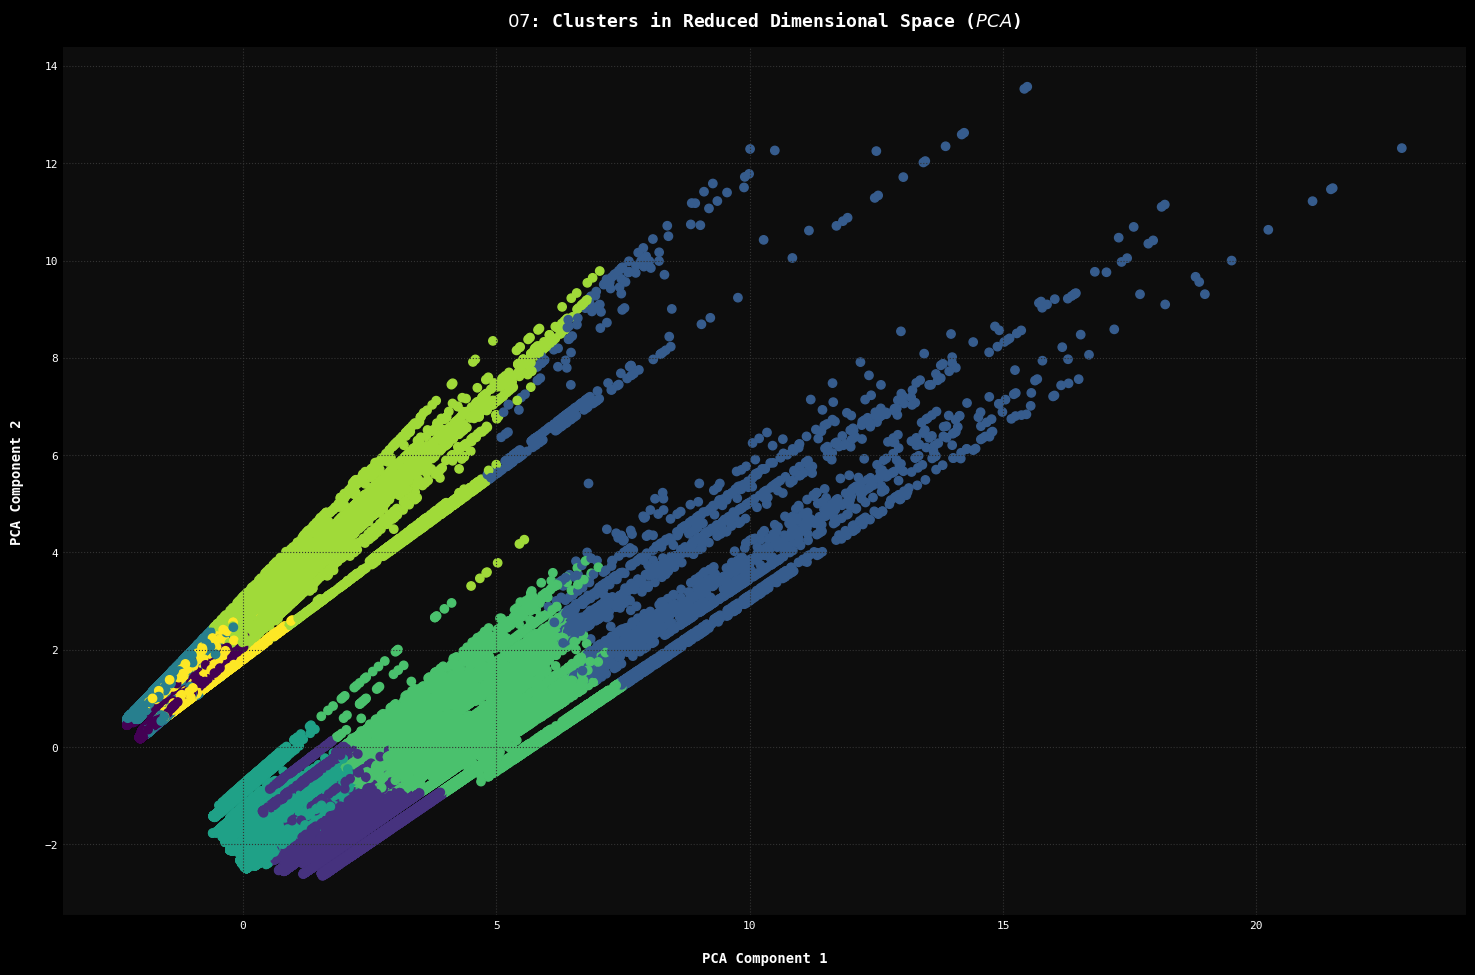

In [8]:
import matplotlib.pyplot as plt

from sklearn.cluster       import KMeans
from sklearn.decomposition import PCA

# Apply K-Means Clustering
kmeans   = KMeans(n_init = 'auto', random_state = 0)
clusters = kmeans.fit_predict(X_train_lasso)

# Dimensionality Reduction for Visualization
pca     = PCA(n_components = 2)
reduced = pca.fit_transform(X_train_lasso)

# Visualizing the clusters in 2D
plt.scatter(reduced[:, 0], 
            reduced[:, 1], 
            c    = clusters, 
            cmap = 'viridis')
plt.title('$07$: Clusters in Reduced Dimensional Space ($PCA$)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/07 - Clusters in Reduced Dimensional Space.png'))
plt.show()

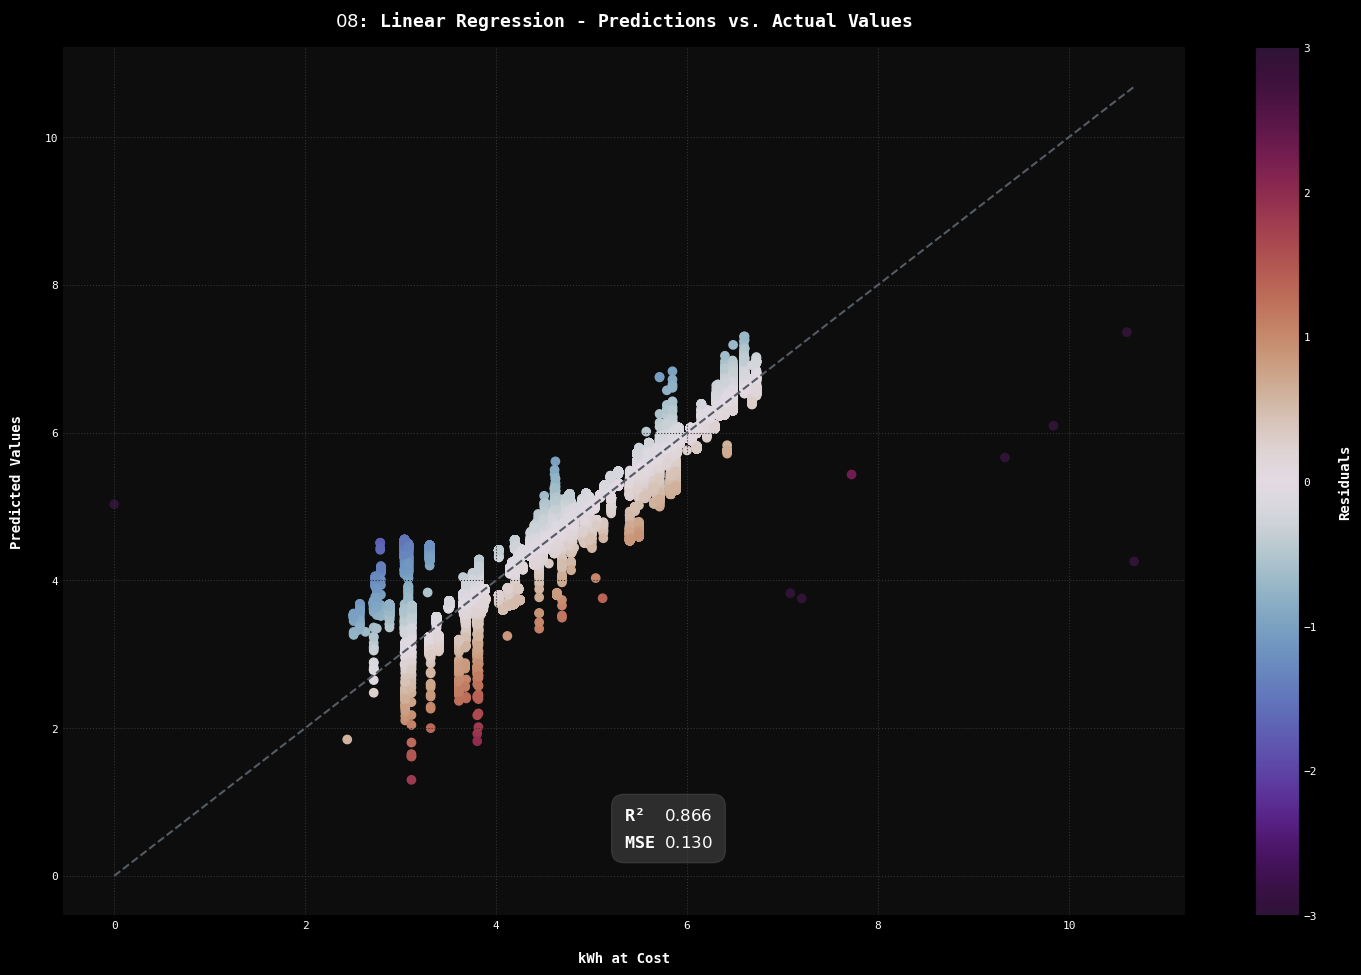

In [9]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, r2_score

# Instantiate and fit the Linear Regression model
linear_regression = LinearRegression()
linear_regression.fit(X_train_lasso, y_train)
y_pred = linear_regression.predict(X_test_lasso)

 # Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = '#545B63', linestyle = '--')

plt.scatter(x = y_test, 
            y = y_pred, 
            c = y_test - y_pred,
            cmap = 'twilight_shifted',
            vmin = -3, 
            vmax = 3,
            edgecolor = None)

plt.text(0.5, 0.1, 
         (f"R²  ${r2_score(y_test, y_pred):.3f}$\n"
          f"MSE ${mean_squared_error(y_test, y_pred):.3f}$"), 
         fontsize = 12, fontweight = 'bold', linespacing = 1.8,
         bbox = dict(facecolor = '0.3', edgecolor = '0.3', boxstyle = 'round,pad = 0.75', alpha = 0.5),
         ha = 'left', va = 'center', transform = plt.gca().transAxes)

plt.title('$08$: Linear Regression - Predictions vs. Actual Values')
plt.xlabel('kWh at Cost')
plt.ylabel('Predicted Values')
plt.colorbar(label = 'Residuals')
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/08 - Linear Regression Predictions vs Actual Values.png'))
plt.show()

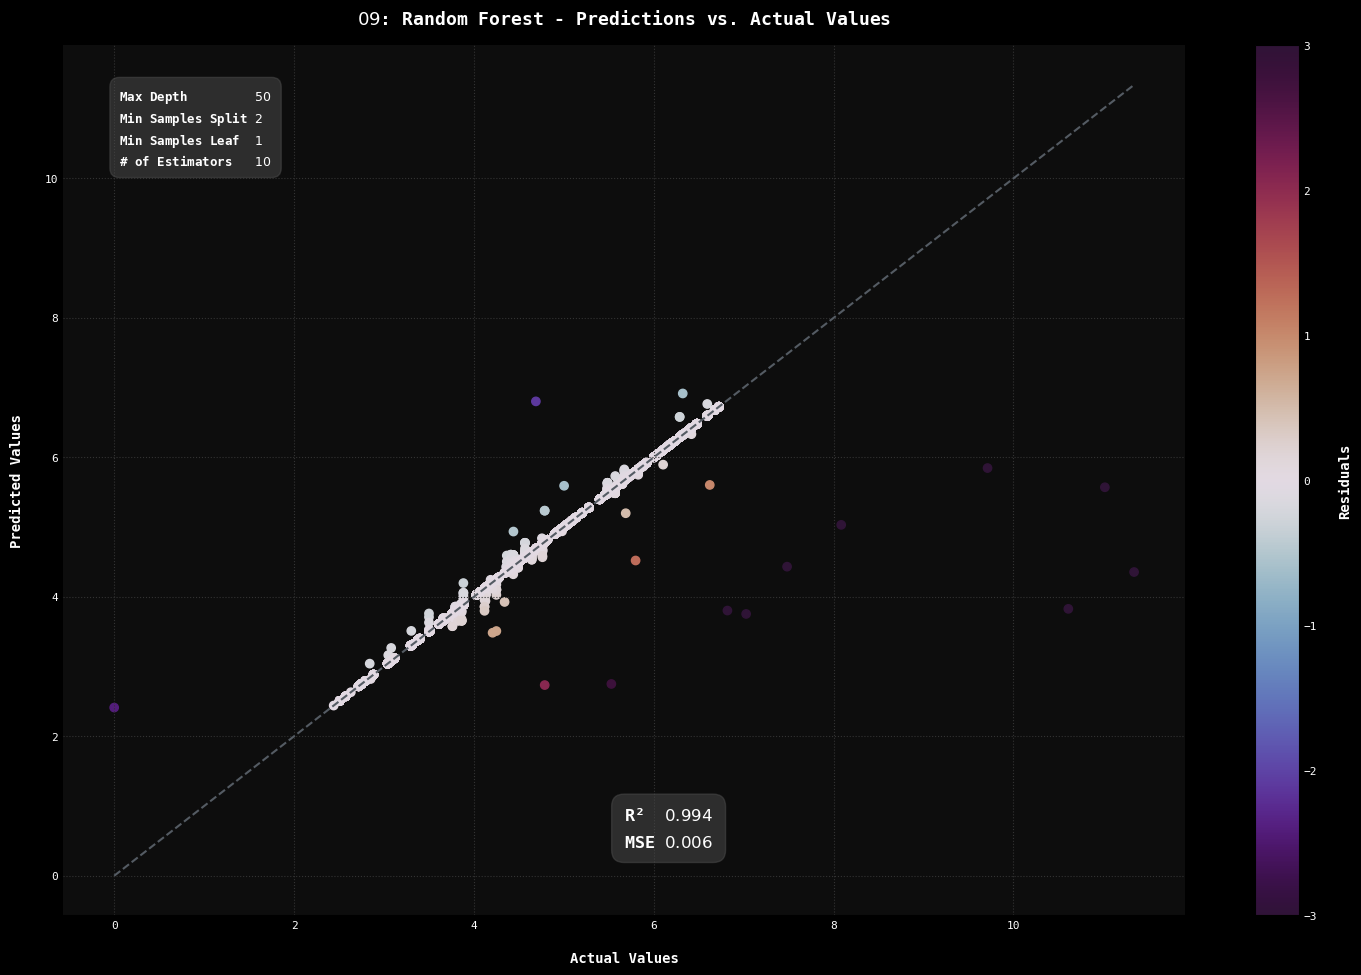

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train_lasso, y_train, random_state=0)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state = 0)

# Hyperparameter Grid
distributions = {'n_estimators'      : [5, 10, 15, 20],
                 'max_depth'         : [10, 20, 50, 100],
                 'min_samples_split' : [2, 4, 8],
                 'min_samples_leaf'  : [1, 2, 4, 8]}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(rf, distributions, n_jobs = -1, random_state = 0)
random_search.fit(X_train_rf, y_train_rf)

# Predictions using the best model
best_rf   = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_rf)

# Perfect prediction line
plt.plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], color = '#545B63', linestyle = '--')

# Scatter plot of actual vs predicted values
plt.scatter(x = y_test_rf, 
            y = y_pred_rf, 
            c = y_test_rf - y_pred_rf,
            cmap = 'twilight_shifted',
            vmin = -3, 
            vmax = 3,
            edgecolor = None)

# Text annotation for R² and MSE
plt.text(0.5, 0.1, 
         (f"R²  ${r2_score(y_test_rf, y_pred_rf):.3f}$\n"
          f"MSE ${mean_squared_error(y_test_rf, y_pred_rf):.3f}$"), 
         fontsize = 12, fontweight = 'bold', linespacing = 1.8,
         bbox = dict(facecolor = '0.3', edgecolor = '0.3', boxstyle = 'round,pad = 0.75', alpha = 0.5),
         ha = 'left', va = 'center', transform = plt.gca().transAxes)

# Second text annotation for hyperparameters (top left)
plt.text(0.05, 0.95, 
         (f"Max Depth         ${best_rf.get_params()['max_depth']}$\n"
          f"Min Samples Split ${best_rf.get_params()['min_samples_split']}$\n"
          f"Min Samples Leaf  ${best_rf.get_params()['min_samples_leaf']}$\n"
          f"# of Estimators   ${best_rf.get_params()['n_estimators']}$"), 
         fontsize = 9, fontweight = 'bold', linespacing = 1.3,
         bbox = dict(facecolor = '0.3', edgecolor = '0.3', boxstyle = 'round,pad = 0.75', alpha = 0.5),
         ha = 'left', va = 'top', transform = plt.gca().transAxes)

plt.title('$09$: Random Forest - Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.colorbar(label = 'Residuals')
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/09 - Random Forest Predictions vs Actual Values.png'))
plt.show()

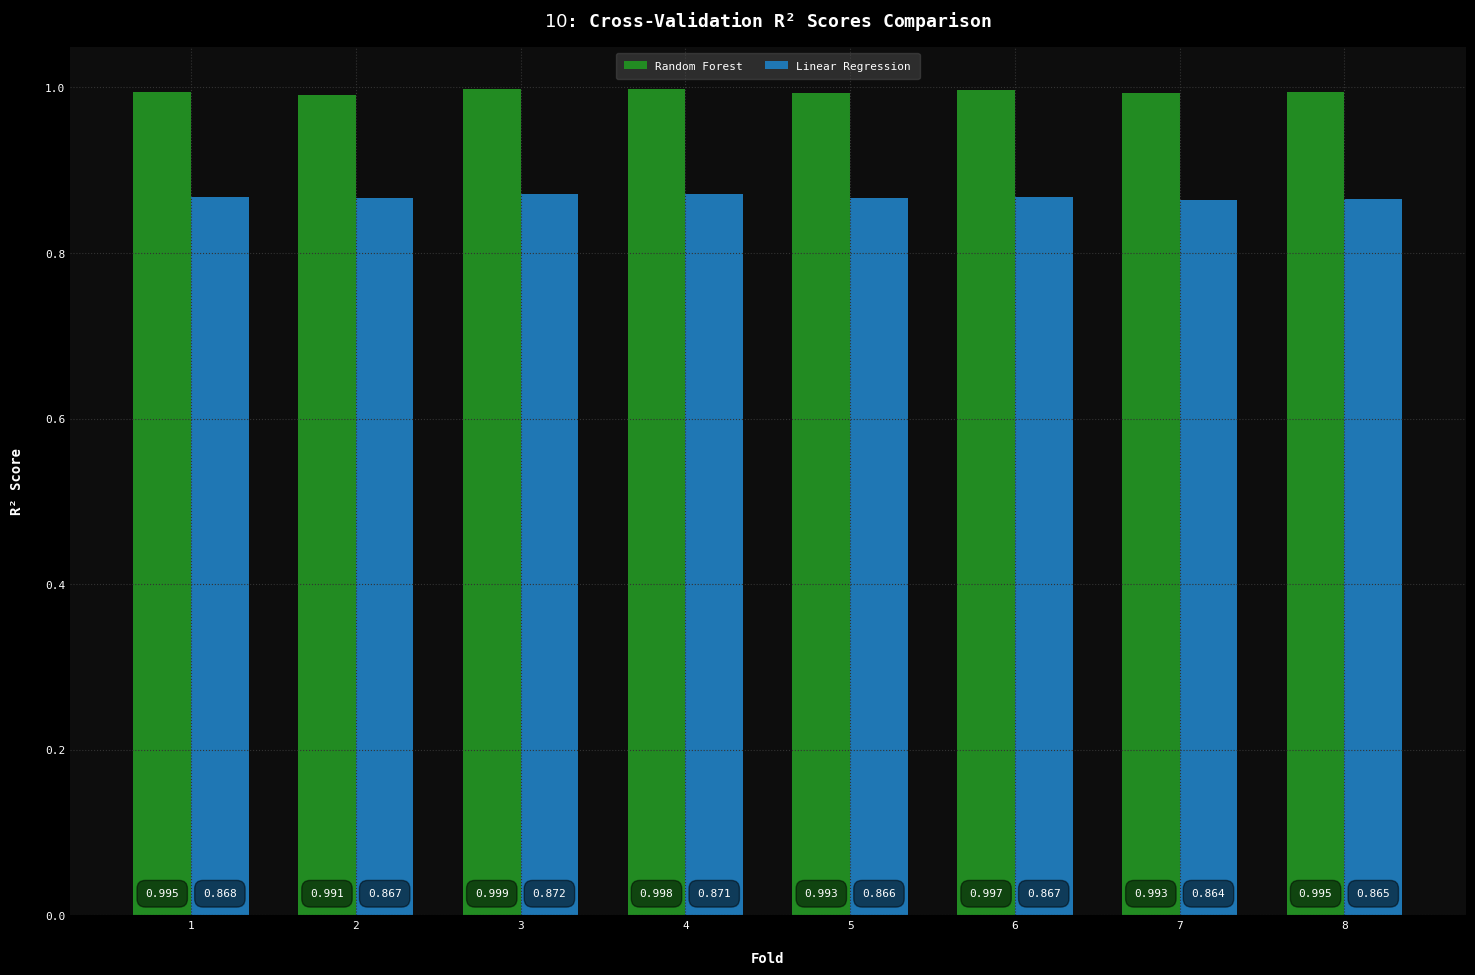

In [11]:
import matplotlib.pyplot as plt

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import cross_val_score

# Perform cross-validation using the best model from Randomized Search and SLR
cv_scores_rf = cross_val_score(best_rf,            X_train_lasso, y_train, cv = 8, scoring = 'r2', n_jobs = -1)
cv_scores_lr = cross_val_score(LinearRegression(), X_train_lasso, y_train, cv = 8, scoring = 'r2', n_jobs = -1)

# Number of folds
n_folds = np.arange(1, len(cv_scores_rf) + 1)

# Bar chart settings
bar_width = 0.35
opacity   = 0.8

# Plotting the bar chart
bars_rf = plt.bar(n_folds - bar_width/2, cv_scores_rf, bar_width, label = 'Random Forest', color = 'forestgreen')
bars_lr = plt.bar(n_folds + bar_width/2, cv_scores_lr, bar_width, label = 'Linear Regression')

# Adding annotations to each bar
for bars in [bars_rf, bars_lr]:
    for bar in bars:

        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, 0.02, f'{height:.3f}', 
                 ha='center', va='bottom',
                 bbox = dict(facecolor = '0', alpha = 0.5, boxstyle = 'round, pad = 0.75'))

plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('$10$: Cross-Validation R² Scores Comparison')
plt.xticks(n_folds)
plt.legend(loc = 'upper center', ncol = 2, title_fontproperties = {'weight': 'bold', 'size': 10})
plt.tight_layout(pad = 2.0)

plt.savefig(find_project_root('./fig/analysis/10 - Cross-Validation R2 Scores Comparison.png'))
plt.show()